In [1]:
using Pkg; Pkg.activate("physics_meets_info")

  Activating project at `~/Cloud/synology/Teaching/physics_and_information/code/physics_meets_info`


# The microscopic origin of an arrow of time

In [2]:
# Import libraries

using LinearAlgebra
using DifferentialEquations
using Zygote
using Plots
using Random
using Distributions

In [3]:
# Definition of physics functions

# A function that computes the potential energy for a given configuration q
function wall_potential(q, barrier=true)
    return sum([sum(exp.(25*(abs.(z).-1.0))) for z in eachcol(q)]) + barrier * sum(exp.(25*q[1,:]))
end

# A function that computes the forces acting on the particles for a given configuration q
function wall_forces(q, barrier=true)
    # Here, we use automatic differentiation to compute the forces via F = - d/dx V(x)
    return -gradient((x)->wall_potential(x,barrier), q)[1]
end

# Random initialization of the configuration; thermal at temperature T
function initialize(N,T; seed=123)
    Random.seed!(seed)
    # 4 coordinates per particle: (p_x, p_y, x, y)
    X = zeros(Float64, 4,N)
    # Maxwell distribution of the velocities
    d = Normal(0.0, 1.0/sqrt(T))
    X[1:2,:] = rand(d, (2,N))
    X[3,:] = 0.9*rand(N).-0.95
    X[4,:] = 1.9*rand(N).-0.95
    return reshape(X, :)
end

# Function defining the right hand side of our equations of motion.
function rhs(X, p, t)
    X = reshape(X, 4, :)
    Xdot = zeros(Float64, size(X)...)
    Xdot[3:4,:] = X[1:2,:]
    Xdot[1:2,:] = wall_forces(X[3:4,:], p)

    return reshape(Xdot,:)
end


# Plotting

function plotfun(u, ts, imb; inset_position=(0.7,0.1,0.25,0.25), Tmax=5)
    u = reshape(u, 4,:)
    xs = u[3,:]
    ys = u[4,:]
    pxs = u[1,:]
    pys = u[2,:]
    ps = sqrt.(pxs.^2+pys.^2)

    p1 = plot(legend=:none, ticks=:none, box=:none, axis_ratio=:equal)
    plot!(1.05*[-1., 1, 1, -1, -1], 1.05*[-1., -1, 1, 1, -1], color=:black)
    xlims!(-1.3,1.3)
    ylims!(-1.3,1.3)
    for q in eachcol(u)
        plot!([q[3], q[3]+0.1*q[1]],[q[4],q[4]+0.1*q[2]],arrow=true, color=:gray)
    end
    scatter!(xs, ys)

    p2 = plot(ts, imb, legend=:none, xlabel="Time", ylabel="Imbalance")
    xlims!(0,Tmax)
    ylims!(0.4,1)

    plot!(p2, inset=bbox(inset_position...), subplot=2)
    histogram!(p2[2], ps, bins=collect(0:0.25:4), normalize=:pdf, legend=:none, framestyle=:box, ticks=:none, title="Velocities")
    vs=collect(0:0.02:4)
    plot!(p2[2], vs,(vs/T).* exp.(-0.5*vs.^2/T))
    ylims!(p2[2], 0,1.1)

    return plot!(p1,p2, size=(800,400))
end

plotfun (generic function with 1 method)

In [4]:
T=1
N=100

X=initialize(N, T)
tspan = (0,5)

problem = ODEProblem(rhs, X, tspan, false)

sol = solve(problem, saveat=0.01, reltol=1e-5);

In [ ]:
imb = [(1.0*sum(reshape(x,4,:)[3,:] .< 0))/N for x in sol.u]
anim = @animate for (i,t) in enumerate(sol.t)
    plotfun(sol.u[i], sol.t[1:i], imb[1:i])
end
gif(anim, "anim_expansion.gif", fps = 15)

In [5]:
tspan = (0,10)

X0 = deepcopy(sol[end])
X0 = reshape(X0, 4, :)
X0[1:2,:] = -X0[1:2,:]
X0 = reshape(X0, :)

problem = ODEProblem(rhs, X0, tspan, false)

sol_echo = solve(problem, saveat=0.01, reltol=1e-5);

In [ ]:
imb = [(1.0*sum(reshape(x,4,:)[3,:] .< 0))/N for x in sol_echo.u]
anim = @animate for (i,t) in enumerate(sol_echo.t)
    plotfun(sol_echo.u[i], sol_echo.t[1:i], imb[1:i]; inset_position=(0.2,0.1,0.25,0.25), Tmax=5)
    if t>5
        break
    end
end
gif(anim, "anim_echo_short.gif", fps = 15)

In [ ]:
imb = [(1.0*sum(reshape(x,4,:)[3,:] .< 0))/N for x in sol_echo.u]
anim = @animate for (i,t) in enumerate(sol_echo.t)
    plotfun(sol_echo.u[i], sol_echo.t[1:i], imb[1:i]; inset_position=(0.2,0.1,0.25,0.25), Tmax=10)
end
gif(anim, "anim_echo.gif", fps = 15)

In [8]:
tspan = (0,10)

X0 = deepcopy(sol[end])
X0 = reshape(X0, 4, :)
X0[1:2,:] = -X0[1:2,:] + 0.05 * randn(2,N)
X0 = reshape(X0, :)

problem = ODEProblem(rhs, X0, tspan, false)

sol_imperfect_echo = solve(problem, saveat=0.01, reltol=1e-5);

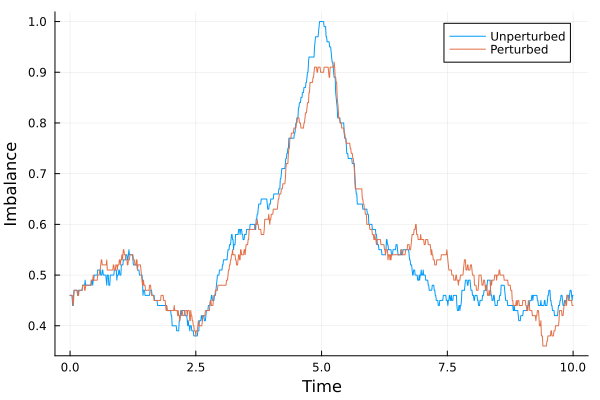

In [9]:
imb_echo = [(1.0*sum(reshape(x,4,:)[3,:] .< 0))/N for x in sol_echo.u]
imb_imperfect_echo = [(1.0*sum(reshape(x,4,:)[3,:] .< 0))/N for x in sol_imperfect_echo.u]
plot(sol_echo.t, imb_echo, xlabel="Time", ylabel="Imbalance", label="Unperturbed")
plot!(sol_imperfect_echo.t, imb_imperfect_echo, label="Perturbed")